In [1]:
import antares

Loading ANTARES from /data0/sw/antares-kernel/lib/python3.9/site-packages/antares/__init__.py

        _    _   _ _____  _    ____  _____ ____
       / \  | \ | |_   _|/ \  |  _ \| ____/ ___|
      / _ \ |  \| | | | / _ \ | |_| |  _| \___ \\
     / ___ \| |\  | | |/ ___ \|  _ /| |___ ___| |
    /_/   \_\_| \_| |_/_/   \_\_| \_\_____|____/   v2.11.0
    


In [2]:
# Imports
import antares.devkit as dk
dk.init()
# You should see a happy message that says that "ANTARES DevKit is ready!"

Jaeger tracer already initialized, skipping


2025-11-05 17:17:12,316 - WARNING MainThread settings.py:setup_prometheus:124 - Prometheus failed to start with [Errno 98] Address already in use
Testing loading a random Locus with `dk.get_locus()`...

ANTARES v2.11.0 DevKit is ready!
Website: https://antares.noirlab.edu
Documentation: https://nsf-noirlab.gitlab.io/csdc/antares/antares/



/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
# Define a Paczyński microlensing model
def paczynski(t, t0, u0, tE, F_s):
    """
    Paczyński microlensing light curve model
    t0 : peak time
    u0 : impact parameter
    tE : Einstein crossing time
    F_s : source flux
    F_b : blended flux
    """
    u = np.sqrt(u0**2 + ((t - t0) / tE) ** 2)
    A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
    return F_s * (A - 1) + (1-F_s)

def mag_to_flux(mag, F0=1.0):
    """
    Convert magnitude to flux.
    
    Parameters:
    - mag : magnitude (float or array)
    - F0 : reference flux (zeropoint), default=1.0 for relative flux
    
    Returns:
    - flux : flux corresponding to the magnitude
    """
    flux = F0 * 10**(-0.4 * mag)
    flux = flux/np.min(flux)
    return flux
    
def magerr_to_fluxerr(mag, mag_err, F0=1.0):
    """
    Convert magnitude uncertainty to flux uncertainty.
    
    Parameters:
    - mag : magnitude value or array
    - mag_err : magnitude uncertainty value or array
    - F0 : zeropoint flux (default=1.0 for relative flux)
    
    Returns:
    - flux_err : flux uncertainty
    """
    flux = mag_to_flux(mag, F0)
    flux_err = 0.4 * np.log(10) * flux * mag_err
    return flux_err

# Writing a preliminary microlensing filter that reads in the photometry

In [11]:
from statsmodels.stats.weightstats import DescrStatsW
import numpy as np
from astropy.table import MaskedColumn
import warnings
import astropy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import skew

#from antares_microlensing_filter import microlensing

class microlensing(dk.Filter):    
    INPUT_LOCUS_PROPERTIES = [
        'ztf_object_id',
    ]

    REQUIRED_TAGS = ['lc_feature_extractor']

    OUTPUT_TAGS = [
        {
            'name': 'microlensing_candidate',
            'description': 'Locus - a transient candidate - exhibits a microlensing-like variability',
        }
    ]


    def make_lc(self, locus):

        with warnings.catch_warnings():
            # The cast of locus.timeseries: astropy.table.Table to a pandas
            # dataframe results in the conversion of some integer-valued
            # columns to floating point represntation. This can result in a
            # number of noisy warning so we will catch & ignore them for the
            # next couple of lines.
            warnings.simplefilter("ignore", astropy.table.TableReplaceWarning)
            df = locus.timeseries.to_pandas()

        data = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']]
        
        dn = data.dropna()
        times=dn['ant_mjd'][dn['ztf_fid']==1]
        mags = dn['ztf_magpsf'][dn['ztf_fid']==1]
        mags_err = dn['ztf_sigmapsf'][dn['ztf_fid']==1]
        flxs = mag_to_flux(mags)
        flx_errs = magerr_to_fluxerr(mags, mags_err)
        
        t0_guess = times[np.argmin(mags)]  # Min mag is peak time
        u0_guess = 1/(np.max(flxs))

        initial_fit  = paczynski(times,
                                     t0_guess, 
                                     u0_guess, 
                                     20, 
                                     0.5)

        # plt.gca().invert_yaxis()
        plt.scatter(times, 
                    flxs, color='g', label='g_band')
        plt.plot(times, 
                 initial_fit, color='b', label='initial fit')
        
        plt.xlabel('Time (mjd)')
        plt.ylabel('Flux')
        plt.legend()

    def is_known_other_phenomenon(self, locus, locus_params):
        """
        Method to check the locus' pre-existing parameters indicated that it has
        been identified or is likely to be a variable of a type other than microlensing

        :param locus:
        :param locus_params:
        :return: boolean
        """

        # Default result is not a known variable
        known_var = False
        
        # Tunable detection thresholds.
        # Ref: Sokolovsky et al. 2016: https://ui.adsabs.harvard.edu/abs/2017MNRAS.464..274S/abstract
        period_peak_sn_threshold = 20.0  # Based on tests with ZTF alerts
        stetson_k_threshold = 0.8  # The expected K-value for a constant lightcurve with Gaussian noise

        # Check for periodicity
        if locus_params['properties']['feature_period_s_to_n_0_magn_r'] >= period_peak_sn_threshold:
            known_var = True

        # Check Stetson-K index
        if locus_params['properties']['feature_stetson_k_magn_r'] <= stetson_k_threshold:
            known_var = True

        # Check whether this event is associated with a GW event
        if 'plausible_gw_events_assoc' in locus.alert.properties.keys():
            known_var = True

        # If the alert has parameters from JPL Horizons, then it is likely cause by
        # a Solar System object
        if 'horizons_targetname' in locus_params['properties'].keys():
            known_var = True

        #FIXME
        #locus.catalog_objects - matched catalog objects from other surveys - RC3 catalog or SDSS etc

        return known_var

    def calculate_eta(self, mag):
        """ Via puzle https://github.com/jluastro/puzle/blob/main/puzle/stats.py"""
        delta = np.sum((np.diff(mag)*np.diff(mag)) / (len(mag)-1))
        variance = np.var(mag)
        eta = delta / variance
        return eta

    def return_eta_residual_slope_offset(self):
        """ 
        Via puzle https://github.com/jluastro/puzle/blob/main/puzle/cands.py
        TODO is 6 months and a year - calculate slope and intercept based on real Rubin data
        """
        slope = 3.8187919463087248
        offset = -0.07718120805369133
        return slope, offset

    def is_microlensing_candidate(self, locus, times, mags, errors):
        """
        Example of a set of Microlensing detection criteria
        """
        if len(times) < 10:  # Too few data points
            return False

        # Extract the full parameter set from the locus and the alert
        locus_params = locus.to_dict()

        # Use the pre-calculated properties of the locus to eliminate those
        # which show signs of variability, e.g. in their periodicity signature or
        # the Stetson-K index
        known_var = self.is_known_other_phenomenon(locus, locus_params)
        if known_var:
            return False

        # Sort data by time
        sorted_idx = np.argsort(times)
        times, mags, errors = times[sorted_idx], mags[sorted_idx], errors[sorted_idx]

        # 1. Check for smoothness (low skewness means symmetric light curve)
        # TODO: Check for threshold with parallax and maybe remove or lower threshold
        if abs(skew(mags)) > 1:
            return False

        # TODO is 6 months and a year - calculate this based on percentile of real data
        eta_thresh = 1.255 # Avg from ZTF level 2 (low eta)
        # Do check for existance since if there's only one band of data, only one will exist
        eta_r_exists = 'feature_eta_e_magn_r' in locus_params['properties'].keys()
        eta_g_exists = 'feature_eta_e_magn_g' in locus_params['properties'].keys()
        eta_r = locus_params['properties']['feature_eta_e_magn_r']
        eta_g = locus_params['properties']['feature_eta_e_magn_g']
        if eta_r_exists and eta_g_exists:
            if eta_r >= eta_thresh and eta_g >= eta_thresh:
                return False
        elif eta_r_exists:
            if eta_r >= eta_thresh:
                return False
        elif eta_g_exists:
            if eta_g >= eta_thresh:
                return False

        # 2. Check variability (microlensing should have a clear peak)
        # Decrease threshold with longer baseline
        # Q for broker - 365 days or full lightcurve?
        if np.ptp(mags) < 0.5:  # Peak-to-peak magnitude difference
            return False

        flxs = mag_to_flux(mags)
        flx_errs = magerr_to_fluxerr(mags, errors)

        # 3. Perform a lightweight template fit (Paczyński model)
        # TODO - Somayeh switch to KMTNet algorithm
        t0_guess = times[np.argmin(mags)]  # Min mag is peak time
        u0_guess = 1/(np.max(flxs))
        initial_guess = [t0_guess, 
                         u0_guess, 
                         20, 
                         0.5]  # Initial params

        # try:
        popt, _ = curve_fit(paczynski, times, flxs, p0=initial_guess, sigma=flx_errs)
        resid = flxs - paczynski(times, *popt)
        chi2 = np.sum((resid / flx_errs) ** 2) / len(times)

        # 4. Apply a simple chi2 threshold
        if chi2 >= 2:  # Poor-fit light curves fails
            return False
        # except RuntimeError:
        #     return False  # Fit failed

        # 5. Check that the residual isn't correlated in all avaliable bands
        eta_resid = self.calculate_eta(resid)
        eta_slope, eta_offset = self.return_eta_residual_slope_offset()
        if eta_r_exists and eta_g_exists:
            if (eta_resid < eta_r*eta_slope + eta_offset) and (eta_resid < eta_g*eta_slope + eta_offset):
                return False
        elif eta_r_exists:
            if (eta_resid < eta_r*eta_slope + eta_offset):
                return False
        elif eta_g_exists:
            if (eta_resid < eta_g*eta_slope + eta_offset):
                return False

        # TODO - Rache potentially query full lightcurve if not already there and if possible

        # TODO - Natasha add microlensing fit with BAGLE

        return True
    def run(self, locus):
        print('Processing Locus:', locus.locus_id)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", astropy.table.TableReplaceWarning)
            df = locus.timeseries.to_pandas()

        data = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']].dropna()

        
        
        # Split into g-band and i-band
        for band in [1, 2]:  # 1 = g-band, 2 = i-band
            band_data = data[data['ztf_fid'] == band]
            times, mags, errors = band_data['ant_mjd'].values, band_data['ztf_magpsf'].values, band_data['ztf_sigmapsf'].values
            
            if self.is_microlensing_candidate(locus, times, mags, errors):
                print(f'Locus {locus.locus_id} is a microlensing candidate in band {band}')
                locus.tag('microlensing_candidate')
        
        
        return

In [5]:
def plot_lightcurve(locus):
    df = locus.timeseries.to_pandas()
    
    data = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']]
    
    dn = data.dropna()
    times=dn['ant_mjd'][dn['ztf_fid']==1]
    mags = dn['ztf_magpsf'][dn['ztf_fid']==1]
    mags_err = dn['ztf_sigmapsf'][dn['ztf_fid']==1]

    plt.errorbar(times, mags, yerr=mags_err, marker = '.', linestyle = 'None')
    plt.gca().invert_yaxis()
    plt.show()

    return


In [12]:
# Execute the microlensing filter on the locus
report = dk.run_filter(microlensing, locus="ANT2023wuk92lk9fz76")


Processing Locus: ANT2023wuk92lk9fz76
Locus ANT2023wuk92lk9fz76 is a microlensing candidate in band 1
Locus ANT2023wuk92lk9fz76 is a microlensing candidate in band 2


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [40]:
'feature_eta_e_magn_r' in report['locus_data'].to_dict()['properties'].keys()

True

In [44]:
print(report['new_tags'])

{'microlensing_candidate'}


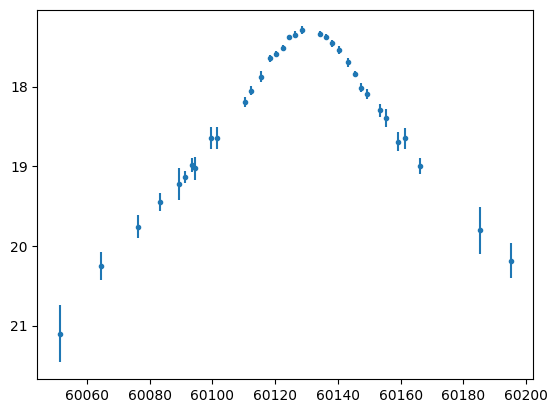

In [13]:
plot_lightcurve(report['locus_data'])

In [19]:
report = dk.run_many(microlensing, n=10)

# `run_many()` returns a report of what the filter did. Take a look at it:
print(report)

/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020qlyec


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020k5skq
Processing Locus: ANT2020mcubc
Processing Locus: ANT2025yjc8dzyswmk9
Processing Locus: ANT2019v3fzo


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020aesf5sq


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020igcyi


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020l66py


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020hmtk4


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020l53w2
{'n': 10, 'results': [{'locus_id': 'ANT2020qlyec', 'locus_data': FilterContext(locus_id="ANT2020qlyec"), 't': 0.049060312999998246, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT2020k5skq', 'locus_data': FilterContext(locus_id="ANT2020k5skq"), 't': 0.045607880999998685, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT2020mcubc', 'locus_data': FilterContext(locus_id="ANT2020mcubc"), 't': 0.04781134199999926, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT2025yjc8dzyswmk9', 'locus_data': FilterContext(locus_id="ANT2025yjc8dzyswmk9"), 't': 0.03974609700000187, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT2019v3fzo', 'locus_data': FilterContext(locus_id="ANT2019v3fzo"), 't': 0.0457232810000

/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020qlyec


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020k5skq
Processing Locus: ANT2020mcubc
Processing Locus: ANT2025yjc8dzyswmk9
Processing Locus: ANT2019v3fzo


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020aesf5sq


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020igcyi


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020l66py


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020hmtk4


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing Locus: ANT2020l53w2
{'n': 10, 'results': [{'locus_id': 'ANT2020qlyec', 'locus_data': FilterContext(locus_id="ANT2020qlyec"), 't': 0.04975789399999897, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT2020k5skq', 'locus_data': FilterContext(locus_id="ANT2020k5skq"), 't': 0.045971480999998704, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT2020mcubc', 'locus_data': FilterContext(locus_id="ANT2020mcubc"), 't': 0.04804035200000101, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT2025yjc8dzyswmk9', 'locus_data': FilterContext(locus_id="ANT2025yjc8dzyswmk9"), 't': 0.03861169500000017, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT2019v3fzo', 'locus_data': FilterContext(locus_id="ANT2019v3fzo"), 't': 0.04680714099999

KeyboardInterrupt: 

822938.4368385181
set()


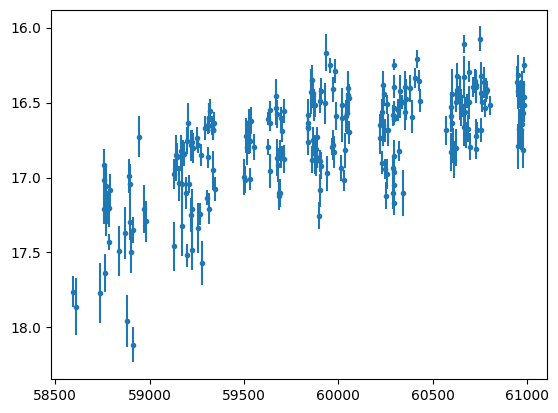

3443246.5377542535
set()


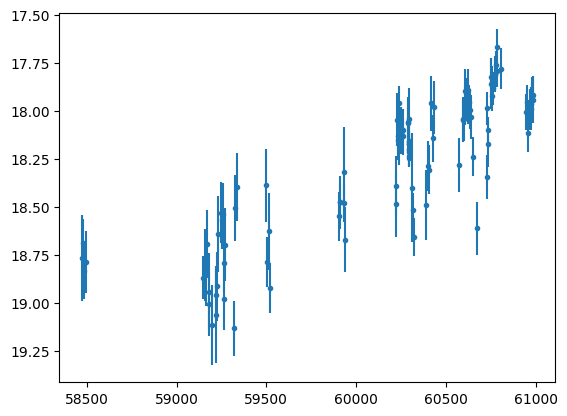

10039270.433903305
set()


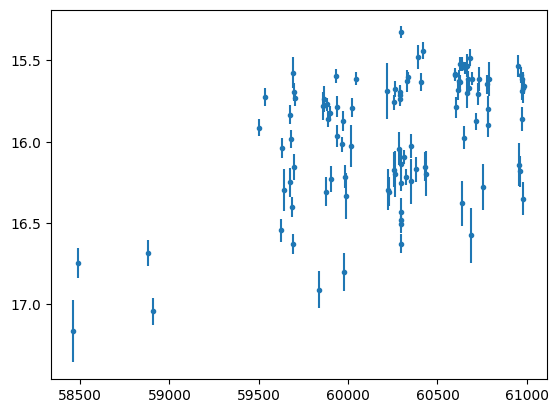

5888437.071147645
set()


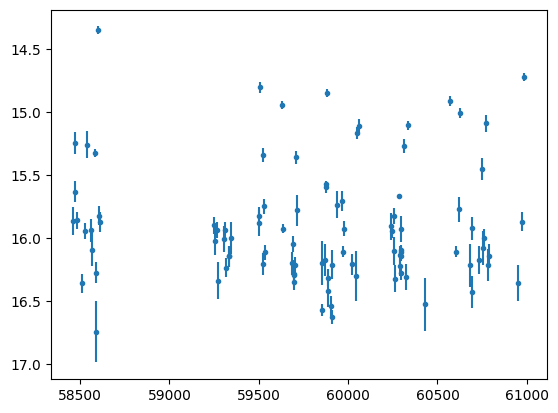

1736462.1547184587
set()


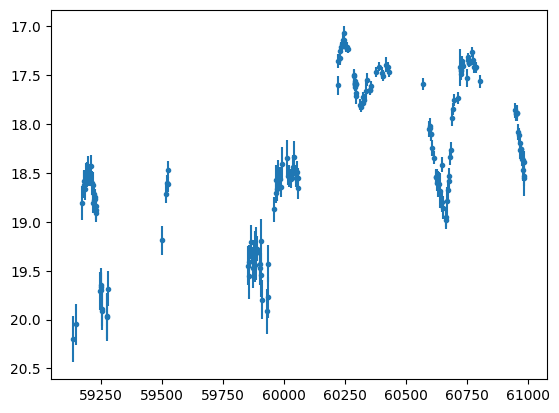

3018876.409849524
set()


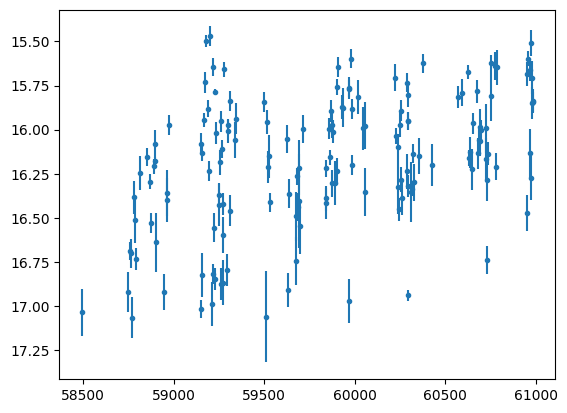

525143.7247465523
set()


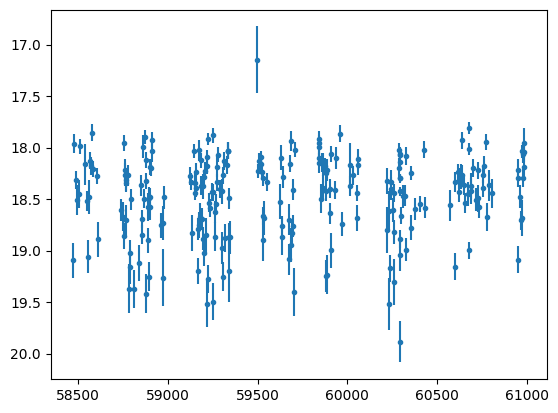

4141236.0610409942
set()


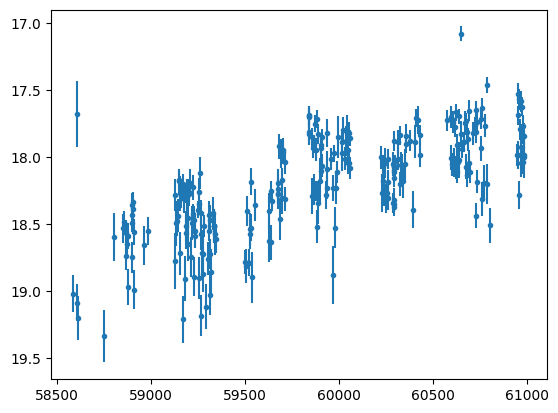

567538.8516759359
set()


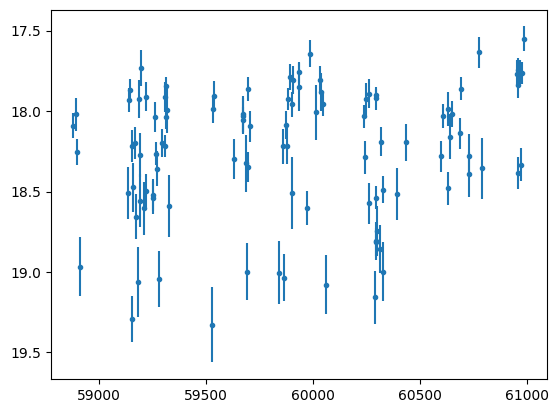

In [20]:
for result in report['results']:
    try:
        print(result['locus_data'].to_dict()['properties']['feature_eta_e_magn_r'])
    except:
        continue
    print(result['new_tags'])
    plot_lightcurve(result['locus_data'])

In [23]:
report['results'][-2]['locus_data'].timeseries.to_pandas()

,alert_id,ant_dec,ant_mag,ant_magerr,ant_maglim,ant_mjd,ant_passband,ant_ra,ant_survey,ant_time_received,...,ztf_tblid,ztf_tooflag,ztf_xpos,ztf_ypos,ztf_zpclrcov,ztf_zpmed,ant_mag_corrected,ant_magerr_corrected,ant_magulim_corrected,ant_magllim_corrected
time,,,,,,,,,,,,,,,,,,,,,
2025-06-05 11:03:39.997452,ztf_upper_limit:ZTF25aaxfccd-3077460873215,NaN,NaN,NaN,20.220900,60831.460880,g,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-09 10:04:26.996165,ztf_upper_limit:ZTF25aaxfccd-3081419753215,NaN,NaN,NaN,19.028601,60835.419757,g,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-12 10:00:31.996796,ztf_upper_limit:ZTF25aaxfccd-3084417033215,NaN,NaN,NaN,17.851601,60838.417037,R,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-12 10:33:57.003824,ztf_upper_limit:ZTF25aaxfccd-3084440243215,NaN,NaN,NaN,18.164301,60838.440243,g,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-14 10:00:53.000624,ztf_upper_limit:ZTF25aaxfccd-3086417283215,NaN,NaN,NaN,19.025499,60840.417280,g,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-18 09:36:41.999040,ztf_upper_limit:ZTF25aaxfccd-3090400483215,NaN,NaN,NaN,19.367800,60844.400486,R,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-18 10:09:09.999377,ztf_upper_limit:ZTF25aaxfccd-3090423033215,NaN,NaN,NaN,19.211800,60844.423032,g,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-20 10:09:43.997744,ztf_upper_limit:ZTF25aaxfccd-3092423423215,NaN,NaN,NaN,19.924101,60846.423426,R,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-20 10:10:25.003195,ztf_upper_limit:ZTF25aaxfccd-3092423904515,NaN,NaN,NaN,19.969601,60846.423900,R,NaN,2,1750766388,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
